### M. Rafy Shah Pahlevi
### 2141720244
### TI - 3E / 19

### Praktikum 1
RNN untuk Analisis Sentimen


In [ ]:
# Impor library yang dibutuhkan
import importlib
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt  # Impor modul pyplot dari matplotlib

def plot_graphs(history, metric):
    plt.plot(history.history[metric])  # Membuat plot dari metrik pelatihan
    plt.plot(history.history['val_'+metric], '')  # Membuat plot dari metrik validasi
    plt.xlabel("Epochs")  # Menambahkan label "Epochs" pada sumbu x
    plt.ylabel(metric)  # Menambahkan label metrik pada sumbu y
    plt.legend([metric, 'val_'+metric])  # Menambahkan legenda ke grafik

In [ ]:
# Memuat dataset IMDb Reviews dan mendapatkan informasi tambahan tentang dataset
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Memisahkan dataset menjadi dua bagian: pelatihan (train_dataset) dan pengujian (test_dataset)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Menampilkan spesifikasi elemen dalam train_dataset
train_dataset.element_spec


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# menggunakan loop for untuk mengambil satu elemen dari train_dataset
for example, label in train_dataset.take(1):
    # mencetak teks (data) dari elemen yang diambil
    print('text: ', example.numpy())
    # mencetak label dari elemen yang diambil
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
# ukuran buffer untuk mengacak dataset pelatihan
BUFFER_SIZE = 10000

# ukuran batch untuk pelatihan
BATCH_SIZE = 64

# mengacak dataset pelatihan, membaginya menjadi batch, dan mengoptimalkan prefetching
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# mengatur dataset pengujian ke dalam batch dan mengoptimalkan prefetching
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# loop untuk mengambil satu batch dari dataset pelatihan dan mencetak contoh teks dan label
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b"In all of low budget history. this movie has to be one of the worst. True ther are some humorous sides to the movie, but in general it was just plain awful. I just can't understand what person could not out run a bunch of slugs. I mean they have to be one of the slowest creatures on the planet. The only part worth while in this movie is the close up of a slugs attempt to bite the finger of a man. This was rather amusing."
 b"I would highly recommend this movie! And I certainly shall be personally recommending it to my friends and family here and abroad! It was with excited anticipation, that I have just pre-ordered it online, I enjoyed it so much! It is not out until February/March 2008, but it will be well worth the wait! But first go and see it in the cinema if you can. There is nothing quite like the Cinema-Experience of a cinema-made movie! Insist that your local cinema puts it on! I went to see 'Seachd, the Inaccessible Pinacle' tonight, down here in London, and was rea

Buat Teks Encoder

In [ ]:
# ukuran vokabuler (jumlah kata unik yang akan diakomodasi)
VOCAB_SIZE = 1000

# Membuat layer TextVectorization dengan maksimum token (kata) sebanyak VOCAB_SIZE
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Mengadaptasi layer encoder ke dataset pelatihan untuk membangun vokabuler
encoder.adapt(train_dataset.map(lambda text, label: text))


In [ ]:
# mendapatkan vokabuler yang dibangun oleh encoder
vocab = np.array(encoder.get_vocabulary())

# menampilkan 20 kata pertama dalam vokabuler
vocab[:20]

# menggunakan encoder untuk mengkodekan contoh teks dan mengambil 3 contoh pertama
encoded_example = encoder(example)[:3].numpy()
encoded_example

# loop untuk mencetak teks asli dan teks yang telah di-decode kembali dari vektor ke teks
for n in range(3):
    print("original: ", example[n].numpy())
    print("round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()


original:  b"In all of low budget history. this movie has to be one of the worst. True ther are some humorous sides to the movie, but in general it was just plain awful. I just can't understand what person could not out run a bunch of slugs. I mean they have to be one of the slowest creatures on the planet. The only part worth while in this movie is the close up of a slugs attempt to bite the finger of a man. This was rather amusing."
round-trip:  in all of low budget history this movie has to be one of the worst true [UNK] are some [UNK] [UNK] to the movie but in general it was just [UNK] awful i just cant understand what person could not out run a bunch of [UNK] i mean they have to be one of the [UNK] [UNK] on the [UNK] the only part worth while in this movie is the close up of a [UNK] attempt to [UNK] the [UNK] of a man this was rather [UNK]                                                                                                                                                

Buat Model

In [ ]:
# Membuat model Sequential
model = tf.keras.Sequential([
    # Layer TextVectorization
    encoder,

    # Layer Embedding dengan input_dim sesuai panjang vokabuler dan output_dim 64
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Menggunakan masking untuk menangani panjang urutan yang bervariasi
        mask_zero=True),

    # Layer Bidirectional LSTM dengan 64 unit
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    # Layer Dense dengan 64 unit dan aktivasi ReLU
    tf.keras.layers.Dense(64, activation='relu'),

    # Layer Dense dengan 1 unit (output)
    tf.keras.layers.Dense(1)
])

# Mencetak status masking untuk setiap layer dalam model
print([layer.supports_masking for layer in model.layers])


[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 9s 9s/step
[-0.0072514]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 59ms/step
[-0.0072514]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Train Model

In [ ]:
# latih model mencoba 10 kali
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)


Epoch 1/10
391/391 [==============================] - 52s 104ms/step - loss: 0.6425 - accuracy: 0.5684 - val_loss: 0.4767 - val_accuracy: 0.7776
Epoch 2/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3943 - accuracy: 0.8198 - val_loss: 0.3579 - val_accuracy: 0.8307
Epoch 3/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3386 - accuracy: 0.8501 - val_loss: 0.3406 - val_accuracy: 0.8427
Epoch 4/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3211 - accuracy: 0.8596 - val_loss: 0.3298 - val_accuracy: 0.8464
Epoch 5/10
391/391 [==============================] - 25s 62ms/step - loss: 0.3111 - accuracy: 0.8662 - val_loss: 0.3251 - val_accuracy: 0.8599
Epoch 6/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3089 - accuracy: 0.8670 - val_loss: 0.3279 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3050 - accuracy: 0.8676 - val_loss: 0.3225 - val_accuracy

In [ ]:
# cek performa model di data pengujian
test_loss, test_acc = model.evaluate(test_dataset)

# tampilkan hasilnya
print('Hasil Ujian:', test_loss)
print('Akurasi Ujian:', test_acc)


391/391 [==============================] - 12s 31ms/step - loss: 0.3235 - accuracy: 0.8639
Hasil Ujian: 0.32346072793006897
Akurasi Ujian: 0.8638799786567688


(0.0, 0.6598450392484665)

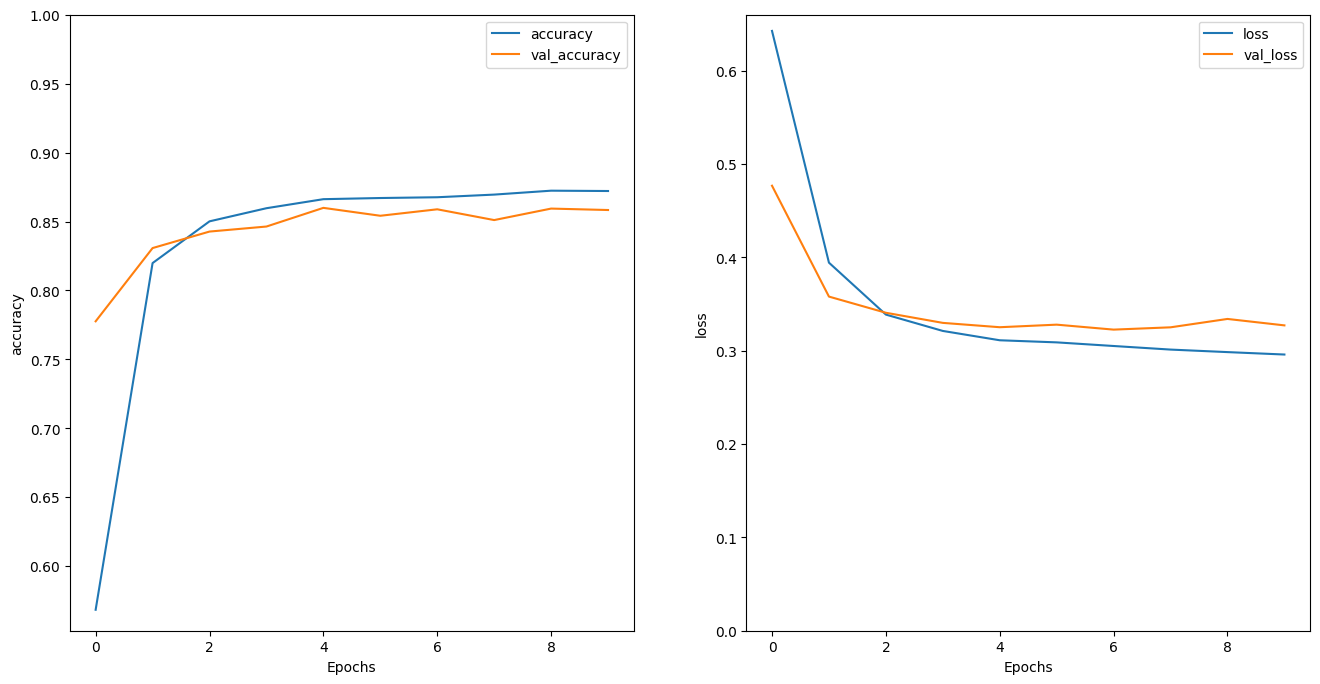

In [ ]:
# Bikin gambar untuk nampilin grafik performa pelatihan
plt.figure(figsize=(16, 8))

# Grafik pertama untuk akurasi
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)

# Grafik kedua untuk loss
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


Stack two or more LSTM layers

In [ ]:
# Buat model dengan beberapa lapisan
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
# Set up model untuk training
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [ ]:
# latih model mencoba 10 kali
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 78s 154ms/step - loss: 0.6299 - accuracy: 0.5871 - val_loss: 0.4440 - val_accuracy: 0.7948
Epoch 2/10
391/391 [==============================] - 48s 123ms/step - loss: 0.3882 - accuracy: 0.8340 - val_loss: 0.3687 - val_accuracy: 0.8464
Epoch 3/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3371 - accuracy: 0.8539 - val_loss: 0.3278 - val_accuracy: 0.8557
Epoch 4/10
391/391 [==============================] - 47s 121ms/step - loss: 0.3202 - accuracy: 0.8632 - val_loss: 0.3226 - val_accuracy: 0.8542
Epoch 5/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3099 - accuracy: 0.8688 - val_loss: 0.3211 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3054 - accuracy: 0.8719 - val_loss: 0.3299 - val_accuracy: 0.8432
Epoch 7/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3015 - accuracy: 0.8718 - val_loss: 0.3185 - val_ac

In [ ]:
# Cek hasil performa model di data pengujian
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 49ms/step - loss: 0.3232 - accuracy: 0.8643
Test Loss: 0.3231757581233978
Test Accuracy: 0.8643199801445007


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.9560647]]


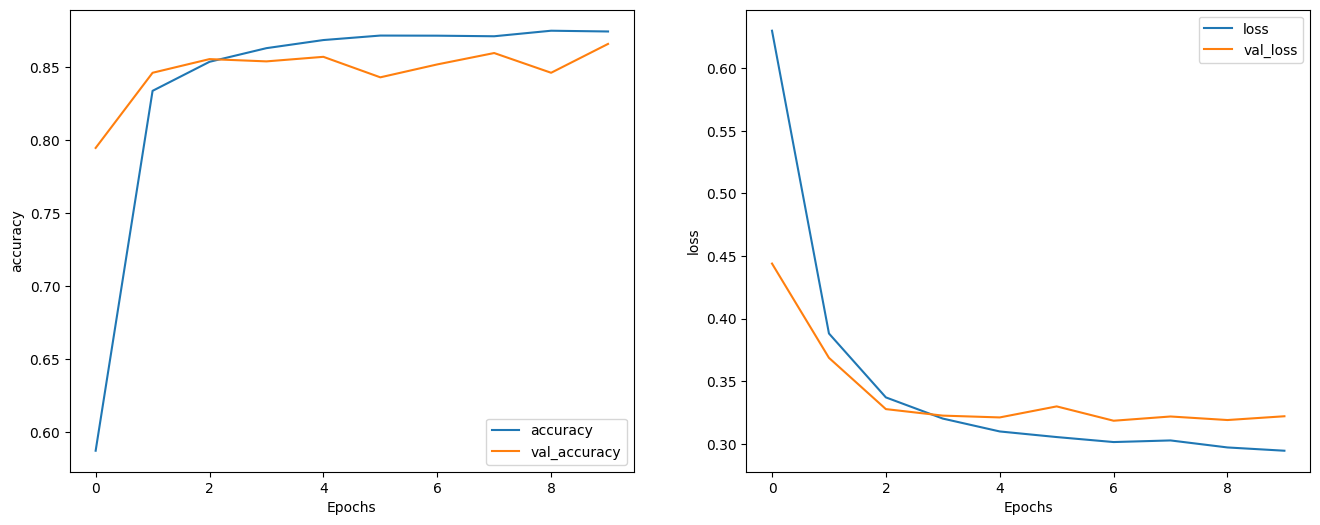

In [ ]:
# Bikin gambar untuk nampilin grafik performa pelatihan
plt.figure(figsize=(16, 6))

# Grafik pertama buat akurasi
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

# Grafik kedua buat loss
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
